### Sample code for FB Prophet forecast

import necessary packages for model

In [16]:
import geopandas as gp
import pandas as pd
import numpy as np
from prophet import Prophet
import datetime as dt

import matplotlib
from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import the ``jsontocsv.py`` to read the raw geojson file as a pandas dataframe without annual averages

In [17]:
import jsontocsv

In [27]:
df = jsontocsv.geojson_to_csv('NASA/POWER_Point_Monthly_Timeseries_1981_2020_046d0562N_118d3476W_LST.json')
print(np.shape(df))

(444, 14)


Rename target variable ``ALLSKY_KT`` to ``y`` and move the ds column into the df (reset index)

In [33]:
indexdf = pd.DataFrame(df['ALLSKY_KT'])
indexdf=indexdf.rename(columns={"ALLSKY_KT": "y"})

data = indexdf.reset_index()
data

,ds,y
0,1984-01-01,0.48
1,1984-02-01,0.46
2,1984-03-01,0.53
3,1984-04-01,0.55
4,1984-05-01,0.55
...,...,...
439,2020-08-01,0.69
440,2020-09-01,0.57
441,2020-10-01,0.59
442,2020-11-01,0.48


### Time-split dataset for testing and training

In [36]:
split_point = len(data) - 70
dataset, validation = data[0:split_point], data[split_point:]

print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

validation


Dataset 374, Validation 70


,ds,y
374,2015-03-01,0.57
375,2015-04-01,0.66
376,2015-05-01,0.62
377,2015-06-01,0.68
378,2015-07-01,0.68
...,...,...
439,2020-08-01,0.69
440,2020-09-01,0.57
441,2020-10-01,0.59
442,2020-11-01,0.48


Creating the Prophet model. 

This step has a lot of variability for processing seasonal data. This was one of the approaches, in which the model's ``seasonality_mode`` was set to 'multiplicative', but other approaches could be used later on with the furutre predictions

In [81]:
model = Prophet(seasonality_mode='multiplicative')
#model=Prophet()
model.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
model.fit(dataset)



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.07508
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       899.805    0.00117603       95.1332      0.6182      0.6182      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       900.444   0.000343491       112.309   3.314e-06       0.001      231  LS failed, Hessian reset 
     199       900.506   1.40601e-06       93.4194       0.431           1      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       900.507    3.9864e-08       95.1578      0.2262           1      322   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [82]:
future = model.make_future_dataframe(periods=70, freq='MS')
predict = model.predict(future)

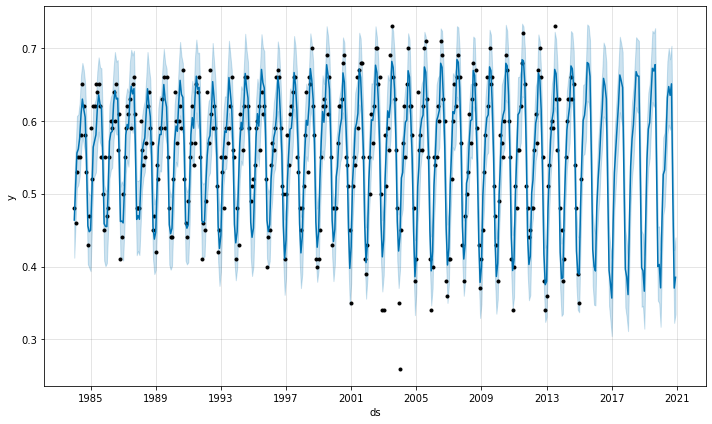

In [83]:
fig = model.plot(predict)

In [88]:
#print(predict)

### Comparing predicted values to actual data (predict vs validation)

In [85]:
MSE = mean_squared_error(validation['y'], predict['yhat'][-70:])
MSE

0.002831229641707242

In [86]:
r2 = r2_score(validation['y'], predict['yhat'][-70:])
r2

0.7537781532531559

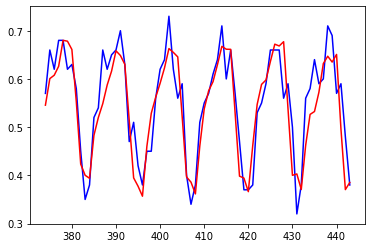

In [87]:
plt.plot(validation['y'], color='blue')
plt.plot(predict['yhat'][-70:], color='red')